# 資料確認

In [34]:
import json
import pandas as pd
from datetime import datetime

In [35]:
idol_name_sheet = pd.read_excel("data/K-POP藝人清單.xlsx", sheet_name = "idols")

with open("data/v2-kpop-challenge-shorts.json", 'r', encoding='utf-8') as f:
    youtube_data = json.load(f)    

## 確認是否有重複名稱

In [36]:
# 檢查是否有重複名稱
k_name = idol_name_sheet["name (korean)"].tolist()
k_name_set = set(k_name)

e_name = idol_name_sheet["name (english)"].tolist()
e_name_set = set(e_name)

korean_name_ratio = len(k_name_set) / len(k_name)
english_name_ratio = len(e_name_set) / len(e_name)

print(f"韓文不重複名稱佔比: {korean_name_ratio * 100:.2f}%")
print(f"英文不重複名稱佔比: {english_name_ratio * 100:.2f}%")

韓文不重複名稱佔比: 94.09%
英文不重複名稱佔比: 98.37%


## 確認是否全部的團體都有資料

In [37]:
group_name_list = set(idol_name_sheet["group (english)"].tolist())
youtube_group_name_list = set(youtube_data.keys())

match_group_ratio = len(youtube_group_name_list) / len(group_name_list)

print(f"有資料的團體佔比: {match_group_ratio * 100:.2f}%")
print(f"沒有資料的團體數量: {len(group_name_list) - len(youtube_group_name_list)}")

有資料的團體佔比: 85.33%
沒有資料的團體數量: 11


# 資料處理

In [38]:
group_name_list = set([ f.upper() for f in idol_name_sheet["group (english)"].tolist()])
group_name_list

{'AB6IX',
 'AESPA',
 'AKMU',
 'APINK',
 'ATEEZ',
 'B1A4',
 'BABYMONSTER',
 'BADVILLAIN',
 'BIGBANG',
 'BILLLIE',
 'BOYNEXTDOOR',
 'BTOB',
 'BTS',
 'CLASSY',
 'CRAVITY',
 'DKB',
 'DREAMCATCHER',
 'ENHYPEN',
 'EPEX',
 'EVERGLOW',
 'EXO',
 'FIFTYFIFTY',
 'GIDLE',
 'GIRLSDAY',
 'GIRLSGENERATION',
 'GOT7',
 'H1KEY',
 'HEARTS2HEARTS',
 'HIGHLIGHT',
 'IKON',
 'ILLIT',
 'ILY1',
 'ITZY',
 'IVE',
 'IZNA',
 'KEP1ER',
 'KICKFLIP',
 'KIIIKIII',
 'KISSOFLIFE',
 'LE_SSERAFIM',
 'MADEIN',
 'MAMAMOO',
 'MEOVV',
 'MONSTAX',
 'NCT127',
 'NCTDREAM',
 'NCTWISH',
 'NEWJEANS',
 'NMIXX',
 'NOWADAYS',
 'OHMYGIRL',
 'ONF',
 'PLAVE',
 'PURPLEKISS',
 'REDVELVET',
 'RIIZE',
 'ROCKETPUNCH',
 'SAYMYNAME',
 'SEVENTEEN',
 'SF9',
 'SHINEE',
 'STAYC',
 'STRAYKIDS',
 'THEBOYZ',
 'TOMORROW_X_TOGETHER',
 'TREASURE',
 'TRIPLES',
 'TWICE',
 'TWS',
 'UNIS',
 'VIVIZ',
 'WINNER',
 'WJSN',
 'YOUNGPOSSE',
 'ZEROBASEONE'}

## 建立藝人與團體的查找表

In [39]:
group_member_dict = {}

for _, idol in idol_name_sheet.iterrows():
    group_belong_to = idol["group (english)"]

    # 為了方便查找，將團體名稱轉換為小寫
    upper_group_name = group_belong_to.upper()

    # 發現 HashTag 有時會出現只有韓文名稱的狀況，因此需要將韓文名稱也加入查找表
    upper_english_name = idol["name (english)"].upper()
    upper_korean_name = idol['name (korean)'].upper()

    if upper_group_name not in group_member_dict:
        group_member_dict[upper_group_name] = []

    group_member_dict[upper_group_name].append(upper_english_name + "," + upper_korean_name)


with open('group_member.json', 'w', encoding='utf-8') as f:
    json.dump(group_member_dict, f, ensure_ascii=False, indent=4)


print(group_member_dict)

{'AB6IX': ['JEONWOONG,전웅', 'KIMDONGHYUN,김동현', 'LEEDAEHWI,이대휘', 'PARKWOOJIN,박우진'], 'AESPA': ['GISELLE,지젤', 'KARINA,카리나', 'NINGNING,닝닝', 'WINTER,윈터'], 'AKMU': ['LEECHANHYUK,이찬혁', 'LEESUHYUN,이수현'], 'APINK': ['BOMI,보미', 'CHORONG,초롱', 'EUNJI,은지', 'HAYOUNG,하영', 'NAEUN,나은', 'NAMJOO,남주'], 'ATEEZ': ['HONGJOONG,홍중', 'JONGHO,종호', 'MINGI,민기', 'SAN,산', 'SEONGHWA,성화', 'WOOYOUNG,우영', 'YEOSANG,여상', 'YUNHO,윤호'], 'B1A4': ['BARO,바로', 'CNU,신우', 'GONGCHAN,공찬', 'JINYOUNG,진영', 'SANDEUL,산들'], 'BABYMONSTER': ['AHYEON,아현', 'ASA,아사', 'CHIQUITA,치키타', 'PHARITA,파리타', 'RAMI,라미', 'RORA,로라', 'RUKA, 루카'], 'BADVILLAIN': ['CHLOEYOUNG,클로이영', 'EMMA,엠마', 'HUE,휴이', 'INA,이나', 'KELLY,켈리', 'VIN,빈', 'YUNSEO,윤서'], 'BIGBANG': ['DAESUNG,대성', 'GDRAGON,지드래곤', 'TAEYANG,태양'], 'BILLLIE': ['HARAM,하람', 'HARUNA,하루나', 'MOONSUA,문수아', 'SHEON,션', 'SIYOON,시윤', 'SUHYEON,수현', 'TSUKI,츠키'], 'BOYNEXTDOOR': ['JAEHYUN,명재현', 'LEEHAN,이한', 'RIWOO,리우', 'SUNGHO,성호', 'TAESAN,태산', 'WOONHAK,운학'], 'BTOB': ['LEECHANGSUB,이창섭', 'LEEMINHYUK,이민혁', 'LIMHYUNSIK,임현식',

## 將影片資訊整理

In [40]:

# 抽取影片中的團體
def getGroupsInVideo(tags):
    groups_in_video = []

    for tag in tags:
        if tag[0] == '#' and (tag[1:].upper() in group_name_list):
            groups_in_video.append(tag[1:].upper())

    return groups_in_video

# 使用團體成員列表查找影片中的合作藝人
def findGroupMember(str, group_members):
    for member in group_members:
        name_split = member.split(",")
        if len(name_split) != 2:
            print(name_split)
            assert False

        english_name,korean_name = name_split
        if str == english_name or str == korean_name:
            return english_name
    return None

# 抽取影片中的合作藝人
def getMembersInVideo(tags, group_list, group_member_dict):
    members_in_video = set()
    for tag in tags:
        for group in group_list:
            member = findGroupMember(tag[1:].upper(), group_member_dict[group])
            if member is not None:
                members_in_video.add((group, member))
    return list(members_in_video)

def get_collaboration_videos(source_group, group_data, group_member_dict):
    collaboration_videos = []
    videos = sorted(group_data['shorts'], key=lambda x: datetime.strptime(x['upload_time'], "%Y-%m-%d %H:%M:%S"))

    for i, video in enumerate(videos):
        print("processing .... ",video['title'], "from ", source_group)
        tags = video['hashtags']
        groups_in_video = getGroupsInVideo(tags)
        
        members_in_video = getMembersInVideo(tags, groups_in_video, group_member_dict)
            
        is_collaboration = len(members_in_video) < 2
        if is_collaboration:
            print(f"This video is not a collaboration video")
            
        if len(members_in_video) < len(groups_in_video):
            print("Can't find all members in video")
            continue

        source_members = [member for member in members_in_video if member[0] == source_group ]
        target_members = [member for member in members_in_video if member[0] != source_group ]

        collaboration_videos.append({
            "source_group": source_group,
            "source_members": source_members,
            "target_members": target_members,
            
            "type": "single" if is_collaboration else "collaboration",
            "timestamp": datetime.strptime(video['upload_time'], "%Y-%m-%d %H:%M:%S").timestamp(),

            "views": video['views'],
            "likes": video['likes'],
            "comments": video['comments']
        })

    print(len(collaboration_videos) / len(group_data['shorts']) * 100, "%")
    return collaboration_videos

In [41]:
collaboration_videos = []
for group in group_name_list:
    if group not in youtube_data:
        print(f"{group} not in data")
        continue
    
    single_group_videos = get_collaboration_videos(group, youtube_data[group], group_member_dict)
    collaboration_videos.extend(single_group_videos)

collaboration_videos = sorted(collaboration_videos, key=lambda x: x['timestamp'])
collaboration_videos

ROCKETPUNCH not in data
processing ....  ZEROBASEONE 꽃이 활짝 폈습니다 🌹 from  ZEROBASEONE
This video is not a collaboration video
Can't find all members in video
processing ....  시작과 끝은 ZEROSE! 너에게 줄게 🌹 from  ZEROBASEONE
This video is not a collaboration video
Can't find all members in video
processing ....  시작과 끝은 ZEROSE! 너에게 줄게 🌹 from  ZEROBASEONE
This video is not a collaboration video
Can't find all members in video
processing ....  조나단이랑 In Bloom 어때~ 🌹 from  ZEROBASEONE
This video is not a collaboration video
Can't find all members in video
processing ....  내 가장 눈부신 지금 #김지웅 #석매튜 에게 줄게 🌹 from  ZEROBASEONE
processing ....  내 가장 눈부신 지금 #리키 #김규빈 에게 줄게 🌹 from  ZEROBASEONE
processing ....  #박명수 꽃이 활~짝 폈습니다 🌹 from  ZEROBASEONE
This video is not a collaboration video
Can't find all members in video
processing ....  #박명수 꽃이 활~짝 폈습니다 🌹 from  ZEROBASEONE
This video is not a collaboration video
Can't find all members in video
processing ....  토요일엔! 𝗭𝗘𝗥𝗢𝗕𝗔𝗦𝗘𝗢𝗡𝗘 & #놀라운토요일 과 'In Bloom' 🌹 from  ZEROBAS

[{'source_group': 'BTOB',
  'source_members': [('BTOB', 'PENIEL')],
  'target_members': [],
  'type': 'single',
  'timestamp': 1630453475.0,
  'views': 134705,
  'likes': 15727,
  'comments': 220},
 {'source_group': 'BTOB',
  'source_members': [('BTOB', 'LEEMINHYUK'), ('BTOB', 'SEOEUNKWANG')],
  'target_members': [],
  'type': 'collaboration',
  'timestamp': 1630468836.0,
  'views': 73751,
  'likes': 10486,
  'comments': 125},
 {'source_group': 'BTOB',
  'source_members': [('BTOB', 'LEECHANGSUB'), ('BTOB', 'PENIEL')],
  'target_members': [],
  'type': 'collaboration',
  'timestamp': 1630468852.0,
  'views': 124453,
  'likes': 14415,
  'comments': 136},
 {'source_group': 'BTOB',
  'source_members': [('BTOB', 'SEOEUNKWANG')],
  'target_members': [],
  'type': 'single',
  'timestamp': 1630555204.0,
  'views': 40153,
  'likes': 7647,
  'comments': 72},
 {'source_group': 'BTOB',
  'source_members': [('BTOB', 'LEEMINHYUK')],
  'target_members': [],
  'type': 'single',
  'timestamp': 16305552

In [42]:

import json
with open('collaboration_videos.json', 'w', encoding='utf-8') as f:
    json.dump(collaboration_videos, f, ensure_ascii=False, indent=4)
len(collaboration_videos)

4324

## 確認合作影片與一般影片的比例

In [43]:
single_group_videos = [video for video in collaboration_videos if video['type'] == 'single']

print(len(single_group_videos) / len(collaboration_videos) * 100, "%")

46.577243293246994 %


## 確認合作影片的觀看趨勢

/var/folders/z8/f3sgj6c57j91g82_1zshpmy40000gn/T/ipykernel_37135/68058769.py:22: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/z8/f3sgj6c57j91g82_1zshpmy40000gn/T/ipykernel_37135/68058769.py:22: UserWarning: Glyph 20316 (\N{CJK UNIFIED IDEOGRAPH-4F5C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/z8/f3sgj6c57j91g82_1zshpmy40000gn/T/ipykernel_37135/68058769.py:22: UserWarning: Glyph 24433 (\N{CJK UNIFIED IDEOGRAPH-5F71}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/z8/f3sgj6c57j91g82_1zshpmy40000gn/T/ipykernel_37135/68058769.py:22: UserWarning: Glyph 29255 (\N{CJK UNIFIED IDEOGRAPH-7247}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/z8/f3sgj6c57j91g82_1zshpmy40000gn/T/ipykernel_37135/68058769.py:22: UserWarning: Glyph 20114 (\N{CJK UNIFIED IDEOGRAPH-4E92}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/z8/f3sgj6c57j91g8

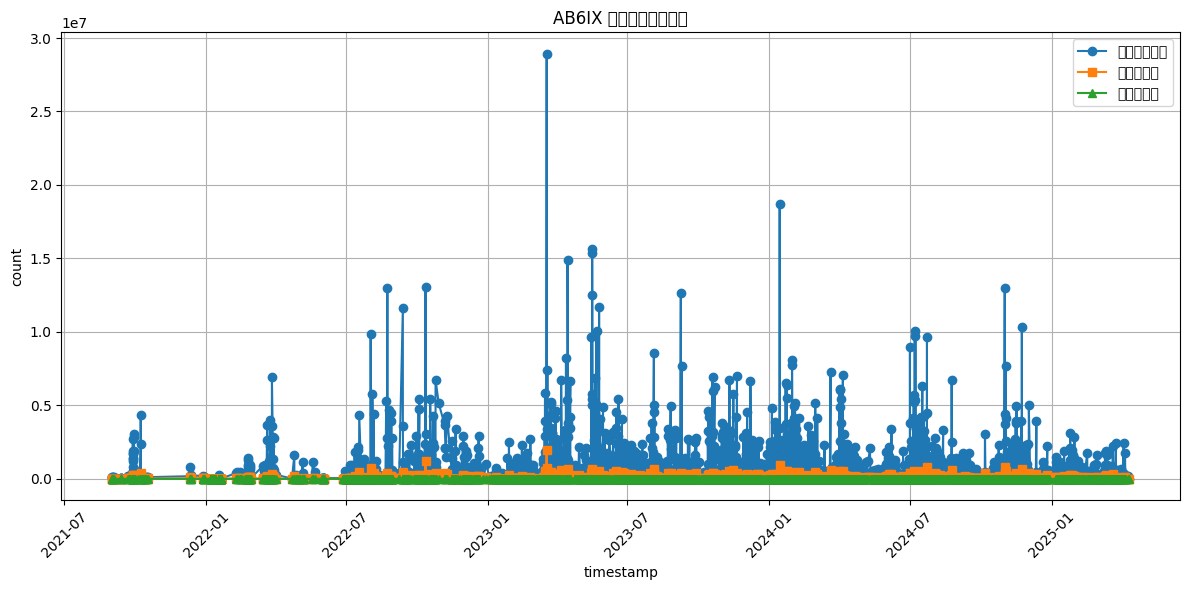

In [45]:
import matplotlib.pyplot as plt
import datetime

collaboration_videos

timestamps = [datetime.datetime.fromtimestamp(video['timestamp']) for video in collaboration_videos]
views = [video['views'] for video in collaboration_videos]
likes = [video['likes'] for video in collaboration_videos]
comments = [video['comments'] for video in collaboration_videos]

plt.figure(figsize=(12, 6))
plt.plot(timestamps, views, label='平均觀看次數', marker='o')
plt.plot(timestamps, likes, label='平均按讚數', marker='s')
plt.plot(timestamps, comments, label='平均留言數', marker='^')

plt.title('AB6IX 合作影片互動趨勢')
plt.xlabel('timestamp')
plt.ylabel('count')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
